<a href="https://colab.research.google.com/github/ayaelsayed25/Image-Segmentation/blob/main/Image_seg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dataset Preparation and Visualization

**Download Dataset**

In [ ]:
!wget http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz

In [ ]:
!pip install mat4py 

In [ ]:
from pprint import pprint
import matplotlib.pyplot as plt
from mat4py import loadmat
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys, tarfile

**Visualize the image and the ground truth segmentation**

In [ ]:
def image_visualization(data):
  fig, axs = plt.subplots(1, 5,figsize=(12,12))
  fig.tight_layout() 
  i = 0
  for value in data['groundTruth'] :
    axs[i].imshow(value['Segmentation'])
    i+=1
  plt.show()
# image_visualization('2018.mat')

In [ ]:
def extract(filename, extract_path):
    try:
        with tarfile.open(filename) as tar:
            tar.extractall(path=extract_path)
    except tarfile.ReadError:
        print("File {} is corrupt".format(filename))
extract('BSR_bsds500.tgz','')

In [ ]:
def read_img(filename) :
  if filename.find('jpg') != -1:
    import matplotlib.pyplot as plt
    # Read in the image
    image = cv2.imread(filename)
    # Change color to RGB (from BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image
  
# read_img('BSR/BSDS500/data/images/test/100007.jpg')

In [ ]:
def read_data(path,reader,limit):
  files = os.listdir(path)
  files.sort()
  data = []
  l = 0
  for filename in files:
    if l == limit :
      break
    data.append(reader(path + filename))
    print(filename)
    l+=1
  return data  

**Read images**

In [ ]:
root = 'BSR/BSDS500/data/images/'
test_img = read_data(root+'/test/',read_img,50)

**Read ground-truth**

In [ ]:
root = 'BSR/BSDS500/data/groundTruth/'
test_ground = read_data(root+'/test/',loadmat,50)

# K-Means

In [ ]:
import random

class k_means :
  def __init__(self,k,epsilon,max_iterations):
    self.k = k
    self.epsilon = epsilon
    self.max_iterations =  max_iterations

  def euclidean(self,point1,point2):
    return np.linalg.norm(point1-point2)
    

  def fit(self,data, reshape):
    print(data.shape)
    if reshape : data = data.reshape((-1,3))
    self.centroids = {}
    #initialize centroids with random values
    for i in range(self.k + 1):
        self.centroids[i] = random.choice(data)

    for _ in range(self.max_iterations):
        self.labels = []
        self.clusters = {}
        for i in range(self.k + 1):
                self.clusters[i] = []
        #assign each point to nearest cluster
        for point in data :
          nearest_cluster = np.argmin([self.euclidean(point,self.centroids[centroid]) for centroid in self.centroids])
          self.labels.append(nearest_cluster)
          self.clusters[nearest_cluster].append(point)
        #calculate new centroids
        previous_centroids = dict(self.centroids)
        for cluster in self.clusters :
          self.centroids[cluster] = np.average(self.clusters[cluster],axis = 0)
        #check whether algorithm converged
        difference = np.sum([self.euclidean(previous_centroids[i],self.centroids[i]) for i in self.centroids])
        print(difference)
        if(difference < self.epsilon) :
          break;

    return np.array(self.labels), list(self.centroids.values())
  
          

In [ ]:
def k_means_segmentation(image, k,epsilon,max_iterations) : 
  model = k_means(k, epsilon, max_iterations)
  new_labels, centers = model.fit(image, True)
  centers = np.uint8(centers)
  segmented_data = centers[new_labels.flatten()]
  segmented_image = segmented_data.reshape((image.shape))
  plt.imshow(segmented_image)
  print(np.unique(segmented_image))

Testing

In [ ]:
k_means_segmentation(test_img[0],k = 3,epsilon = 0.1,max_iterations = 50)
image_visualization(test_ground[0])

# Evaluation of segmented images

In [ ]:
average_measure=0
average_entropy=0
for i in range(1, 51,1) :
  measure,c_entropy=k_means_segmentation(test_img[i],k = 11,epsilon = 0.1,max_iterations = 5,n=i)
  average_measure+=measure
  average_entropy+=c_entropy
average_measure=average_measure/50
average_entropy=average_entropy/50
print("average f_measure of the dataset = "+str(average_measure))
print("average conditional_entropy of the dataset = "+str(average_entropy))
#image_visualization(test_ground[2])

# F-measure

In [ ]:
from sklearn.metrics import fbeta_score
def F_measure(image,ground_truth) :
  #print(len(image))
  #print(image)
  avg_trails=0
  for value in ground_truth['groundTruth'] :
    temp =np.array(value['Segmentation'])
    #print(temp)#print(len(temp))
    ground_seg=temp.flatten()
    #print(ground_seg)
    score=fbeta_score(image,  ground_seg, average='macro',beta=0.5)
    #print("F_measure = "+str(score))
    avg_trails+=score
  return avg_trails/5


   


# Conditional Entropy





In [ ]:
import math
import numpy as np
from collections import Counter
def conditional_entropy(Y,X):
  avg_trails=0
  for value in Y['groundTruth'] :
    temp =np.array(value['Segmentation'])
    #print(temp) #print(len(temp))
    ground_seg=temp.flatten()
    entropy_conditional =conditional(ground_seg,X)
    #print("condition entropy = "+str(entropy_conditional))
    avg_trails+=entropy_conditional
  return avg_trails/5

    
def entropy(Y):
        e = 0.
        total = len(Y)
        if total <= 1:
            return 0
        for num in Counter(Y).values():
            p = num/total
            e -= p * math.log2(p)
        return e 

def conditional(Y,X):
  def indices(v,X):
    return [i for i, j in enumerate(X) if j == v]
  ce = 0.
  total = len(Y)
  for label in Counter(X).keys():
     sv = [Y[i] for i in indices(label,X)]
     e = entropy(sv)
     ce += e * len(sv)/total
  return ce



     

#Big Picture



**Normalized-cut Segmentation**

Clustering

In [ ]:
from sklearn.cluster import SpectralClustering
def spectral_clustering_5nn(img, k):
  clustering = SpectralClustering(n_clusters=k ,assign_labels='kmeans',
                                  affinity='nearest_neighbors', n_neighbors= 5, random_state=0).fit(img)
  return clustering.labels_

Normalized-cut Segmentation

In [ ]:
labels = None

In [ ]:
def normalized_cut_seg(image, data):
  k = 5
  shape = image.shape[0:2]
  img = image.reshape((-1,3))
  labels = spectral_clustering_5nn(img, k)
  filename = "test" + str(i) + ".txt"
  np.savetxt(filename, labels, delimiter=',')
  plt.imshow(labels.reshape(shape))
  print("Segmented Image: ")
  plt.show()
  print("Image: ")
  plt.imshow(image)
  print("Ground truth segmentation: ")
  image_visualization(data)

Test image segmentation against ground truth segmentation

In [ ]:
root = 'BSR/BSDS500/data/images/test/8068.jpg'
image = read_img(root)
root = 'BSR/BSDS500/data/groundTruth/test/8068.mat'
data = loadmat(root)
normalized_cut_seg(image, data)

**Test k-means image segmentation against ground truth segmentation**

(321, 481, 3)
214.92129856173412
127.1499108305779
50.923683424086725
31.624924857669562
21.924363204495904
16.090844950802897
12.850206790011933
11.359316104138687
10.841439720684605
11.228764908922146
10.558666452871167
11.726081828936172
11.995719590758025
11.812540149297343
11.768102791325513
11.145386910650009
10.65231288041413
9.474798397007097
8.046018654646527
7.565305798096413
6.295942399457956
5.028460430585289
4.563232736591541
3.905621549161426
3.0818827891225835
2.4435521471948403
2.4579376730290443
2.0184752318357275
1.594845836039828
1.4373183392119524
1.156547004711958
0.8041775692061779
0.6323153568397976
0.39149236160504614
0.44860727598665845
0.3444183645174819
0.21526076266031413
0.25697603379786815
0.11687169877958717
0.07148163065672201
[ 48  58  60  85 101 103 131 142 155 174 191 193 194 215 220 222 223]


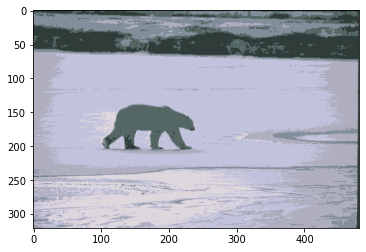

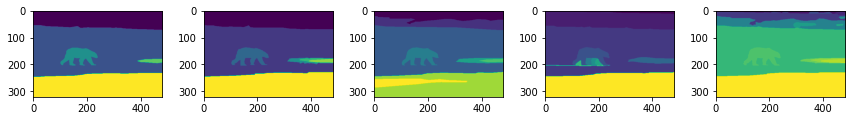

(321, 481, 3)
561.4664106443514
94.90605712954631
45.8975788662455
26.23710578639185
15.49162594429444
10.23843272066561
7.103369141216607
5.339105315288285
4.3579106181790355
3.3552572237578167
2.7220728381813943
2.4807370366847468
2.2612163437160597
2.0595387221226047
1.905224969122297
1.8699567284349798
1.8517875577420777
1.7041099252300194
1.4856702590290312
1.3994551747071253
1.2360887554810298
1.1178657475432465
1.05031613151401
0.9813512995136162
1.0129034971192812
0.965260740507569
0.9053766518949937
0.9311442853430277
0.8131337303310532
0.8126860800048162
0.7344198683462808
0.5901552347423926
0.5843643421373826
0.5118249542180253
0.5535684832901984
0.5658203220462873
0.486578154078512
0.49193855057951297
0.5224112931261452
0.4961480025916235
0.5440535827433696
0.5068802435592384
0.4014693030557195
0.41150350944537084
0.3120494432283429
0.2021515435964647
0.27957149065246184
0.23338601117081667
0.18864099265046858
0.182298850041557
[ 47  55  58  83  87 105 108 118 136 139 154 1

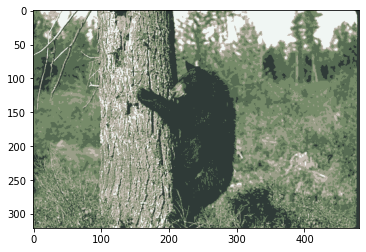

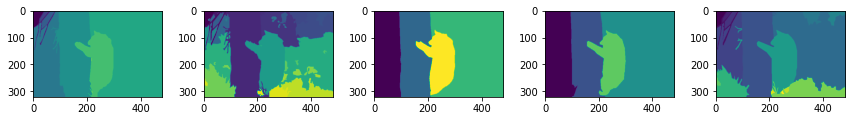

(321, 481, 3)
214.9008034729805
122.18240237912188
37.24590835018774
23.11827428473451
17.885300419925677
14.160111976673033
12.420071421483346
10.583436232686863
10.026754697674626
8.455455915620206
7.782477628659526
7.542296700508464
7.026341926638375
6.050731471717882
5.311644854893611
4.815212913226981
4.363276972574717
3.617000347949299
2.9333014406187496
2.500793372724466
2.03513233796397
1.2597801087160603
0.8624717630305174
0.7417274143465227
0.6510249999033371
0.40298817836795925
0.22672434340302877
0.22053900409746002
0.19542901787554606
0.18866139839276333
0.08600676419097676
[ 40  58  62  68  86  88  98 101 106 123 131 144 156 167 181 220]


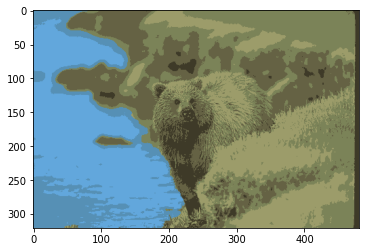

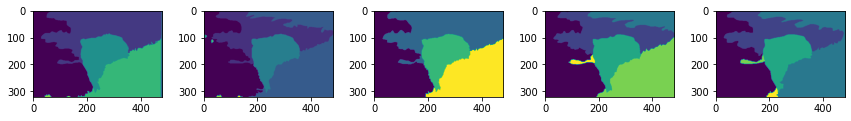

(321, 481, 3)
257.47135199048694
61.42511507116546
36.193965170252234
26.70260409386701
23.37508279098685
23.92682785486602
25.250642097387935
22.989583289422008
19.700948149550776
15.711179369176445
11.745436203474776
9.731522060581643
8.2171147204822
6.143768833058676
5.231997045829738
4.382360402504938
3.475648513183352
2.8623225313363285
2.0674767645955705
1.7387574617613417
1.2042830948035879
1.1090498393842252
0.9310511454913698
0.8711626112040103
0.5847531036633803
0.3448536698985948
0.32555880841582713
0.1909320444703721
0.06881355444230028
[ 26  53  56  60  92  97 106 123 125 140 151 153 155 175 202 208 210 219]


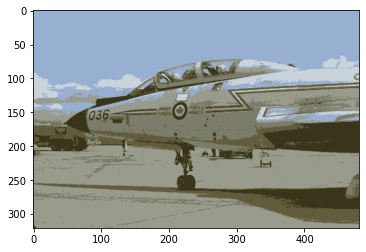

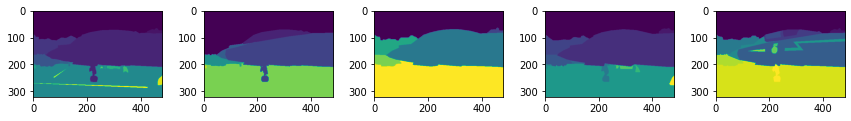

(321, 481, 3)
299.22536268989234
89.83736742646951
50.8922969850181
37.03526625267625
29.524313667854866
25.372682864673514
24.244435226430046
26.36410429362968
25.589594094003015
22.502584884898706
22.321117815859147
22.511534686500394
18.48637680435957
15.146047961287413
13.288530832912848
11.81950822806264
10.536256693914726
9.402443601210882
7.974297209213213
7.059135211971495
5.815144652807216
4.835884571887744
3.9158506215340108
3.0098734138826075
2.322006922602731
1.929722408365953
1.6087135783819326
1.5223628498412742
0.8755205065882141
0.7871653313229617
0.6347169874444647
0.509517843199013
0.3048503627204515
0.34815796605825555
0.13430028186596854
0.12788023603809054
0.09795049293771449
[  6   9  35  38  49  82  83  90  95 104 123 136 145 155 170 219 231 238]


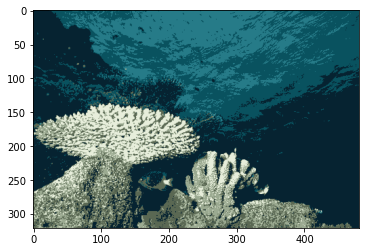

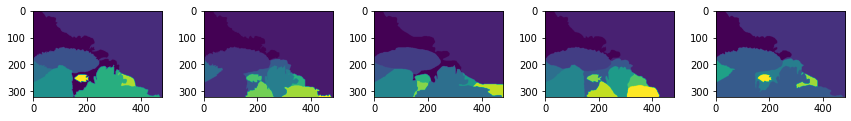

In [ ]:
for i in range(5):
  k_means_segmentation(test_img[i],k = 5,epsilon = 0.1,max_iterations = 50)
  image_visualization(test_ground[i])

**Test k-means image segmentation against Normalized-cut segmentation**

#Extra

In [ ]:
def get_int_from_RGB(rgb):
    red = rgb[0]
    green = rgb[1]
    blue = rgb[2]
    RGBint = (red<<16) + (green<<8) + blue
    return RGBint

In [ ]:
def modify_img(img): #convert image to 2d array by turning the rgb array into int value 
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      rgb = img[i, j]
      value = get_int_from_RGB(rgb)
      img[i, j] = value
  print(img.shape)


In [ ]:
im = test_img[0]
print(im.shape)
modify_img(im)
print(im.shape)

(321, 481, 3)
(321, 481, 3)
(321, 481, 3)


In [ ]:
def k_means_seg(image, k,epsilon,max_iterations) : 
  model = k_means(k, epsilon, max_iterations)
  new_labels, centers = model.fit(image, False)
  centers = np.uint8(centers)
  segmented_image = centers[new_labels.flatten()]
  plt.imshow(segmented_image)

(321, 481, 3)
(321, 481, 3)
12251.638327936114
1901.5645942784445
1556.8434071850147
872.710364003297
609.0170048669908
90.77370790855997
86.12911534713703
0.0


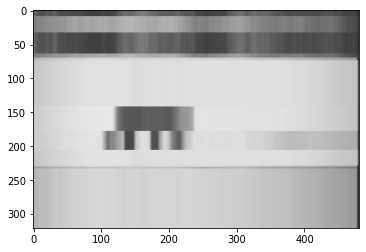

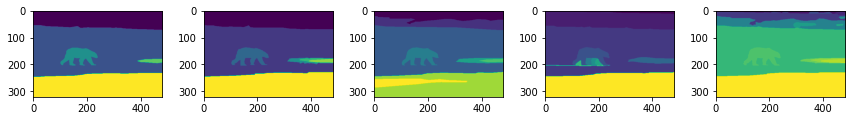

(321, 481, 3)
(321, 481, 3)
11364.329561400637
3766.066716198971
1864.4217776909306
1426.8839567750979
749.2636811904678
489.8556345232478
515.2745379221277
327.82146348276774
203.63633452493548
127.88695842267
202.404637832488
207.23250368459458
218.43855521084015
152.76776796870746
218.73597402946953
276.26829649729615
382.20638340206585
312.5635680036034
45.924637716402884
43.410845889326254
0.0


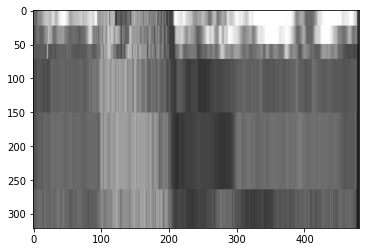

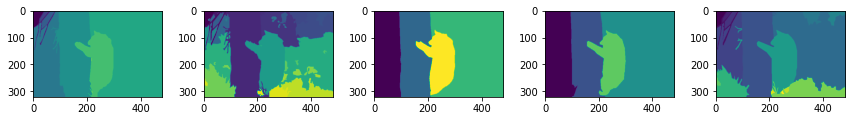

(321, 481, 3)
(321, 481, 3)
9577.683382327057
3935.161573613256
1238.4955973363244
268.243715138344
92.72033067150213
0.0


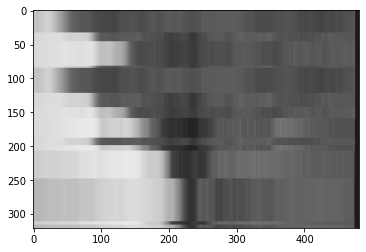

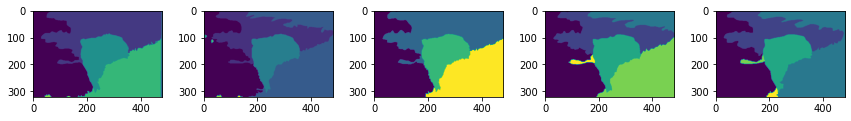

(321, 481, 3)
(321, 481, 3)
14624.461711743159
4372.420025391288
819.1815485380371
779.0396487046849
1124.056603091809
436.07070979588224
405.947192718032
370.7332068499093
202.5451059031769
75.90410427803937
0.0


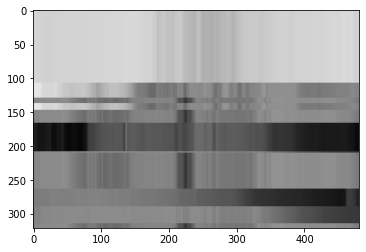

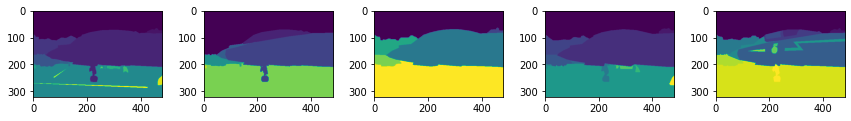

(321, 481, 3)
(321, 481, 3)
9087.361379102394
2849.6553165896244
696.9728252721947
398.3140532895386
204.35047506361974
355.5406786336524
894.7515216657321
175.92483130851343
92.78071196951564
105.04044290590176
215.62525130892794
268.7325635454596
159.79816856926828
286.810285847343
330.0785356933055
147.63363728348992
102.15794422600675
113.59858103553613
212.16840761899087
246.65358647243525
826.9308191045715
330.2049707044488
312.6417046950171
89.11260372952634
0.0


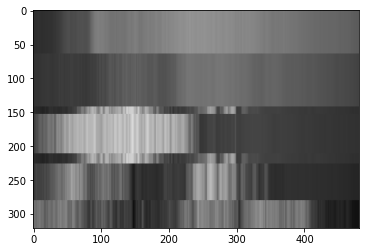

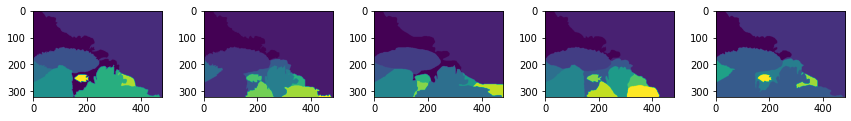

In [ ]:
for i in range(5):
  image = test_img[i]
  modify_img(image)
  k_means_seg(test_img[i],k = 5,epsilon = 0.1,max_iterations = 50)
  image_visualization(test_ground[i])